In [1]:
!pip show keras

Name: keras
Version: 3.3.3
Summary: Multi-backend Keras.
Home-page: https://github.com/keras-team/keras
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache License 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, rich
Required-by: keras-tuner, tensorflow


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
from datasets import Dataset
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

Using TensorFlow backend


In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: xlabel='target', ylabel='count'>

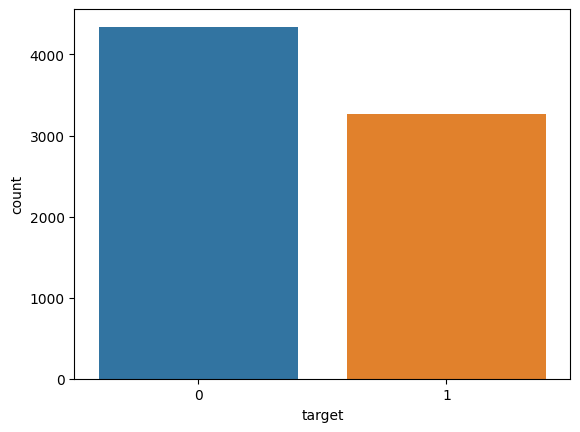

In [5]:
sns.countplot(x='target', data=df_train)

In [6]:
df_train['text_cleaned'] = df_train['text'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
df_test['text_cleaned'] = df_test['text'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
df_train.head()

,id,keyword,location,text,target,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [8]:
def tokenize_function(dataset):
    return tokenizer(dataset['text_cleaned'], padding='max_length', truncation=True) 

# Convert your Pandas DataFrame to a Hugging Face Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Apply the tokenize function to the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

In [9]:
train_dataset

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'text_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7613
})

In [10]:
test_dataset

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'text_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3263
})

In [11]:
from sklearn.model_selection import train_test_split

X = train_dataset["text"]
y = train_dataset["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_dataset["text"]

In [12]:
import os
from os import listdir

# Path to the checkpoint file you want to delete
checkpoint_path = '/kaggle/working/Checkpoints/distil_bert_checkpoint.h5'

# Check if the file exists
if os.path.exists(checkpoint_path):
    # Delete the file
    os.remove(checkpoint_path)
    print(f"Deleted the checkpoint file: {checkpoint_path}")
else:
    print(f"The file {checkpoint_path} does not exist")

The file /kaggle/working/Checkpoints/distil_bert_checkpoint.h5 does not exist


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

distil_bert_mc = ModelCheckpoint(
    monitor='val_accuracy', 
    filepath='Checkpoints/distil_bert_checkpoint.keras',  # Use .keras extension
    verbose=1, 
    save_best_only=True, 
    mode='auto'
)

distil_bert_cd = [distil_bert_mc]


start = datetime.now()

In [14]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets")

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

In [15]:
classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Compile the model
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # 'binary_crossentropy' for binary classification
    optimizer=Adam(learning_rate=1e-5),  # Correct Adam optimizer
    metrics=["accuracy"]
)

In [17]:
# Fit
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=32,
                         callbacks=distil_bert_cd,
                         epochs=10, 
                         validation_data=(X_val, y_val)
                        )

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10


I0000 00:00:1726508390.737513     527 service.cc:145] XLA service 0x784478004700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726508390.737579     527 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726508390.737584     527 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726508415.134990     560 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_14689', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1726508420.682694     560 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_40', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1726508440.946920     527 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_35', 64 bytes spill stores, 64 bytes spill loads
ptxas 

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7202 - loss: 0.5730

I0000 00:00:1726508536.049683     593 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_235', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726508541.149200     595 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_247', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1726508542.623598     593 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_235', 1256 bytes spill stores, 1212 bytes spill loads

I0000 00:00:1726508563.381296     529 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_27', 64 bytes spill stores, 64 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.7205 - loss: 0.5726
Epoch 1: val_accuracy improved from -inf to 0.84242, saving model to Checkpoints/distil_bert_checkpoint.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 203s 715ms/step - accuracy: 0.7207 - loss: 0.5722 - val_accuracy: 0.8424 - val_loss: 0.3925
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8428 - loss: 0.3808
Epoch 2: val_accuracy improved from 0.84242 to 0.84504, saving model to Checkpoints/distil_bert_checkpoint.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 86s 449ms/step - accuracy: 0.8429 - loss: 0.3807 - val_accuracy: 0.8450 - val_loss: 0.3850
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8704 - loss: 0.3296
Epoch 3: val_accuracy did not improve from 0.84504
191/191 ━━━━━━━━━━━━━━━━━━━━ 83s 432ms/step - accuracy: 0.8704 - loss: 0.3295 - val_accuracy: 0.8359 - val_loss: 0.3967
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8929 - loss: 0.2833
Epoch 4: val_accuracy di

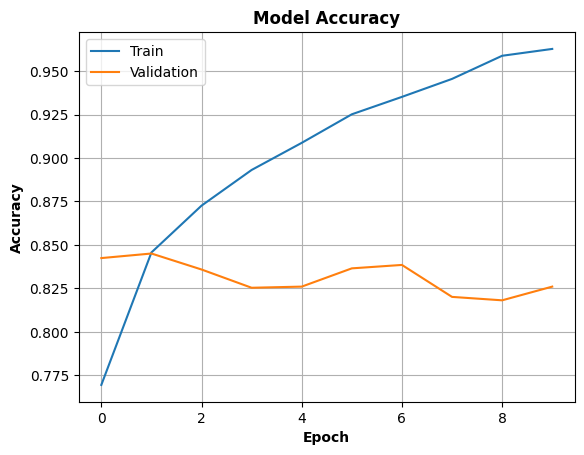

In [18]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10, fontweight='bold')
plt.ylabel('Accuracy', fontsize=10, fontweight='bold')
plt.legend(['Train', 'Validation'])
plt.grid(True)  # Add grid
plt.show()

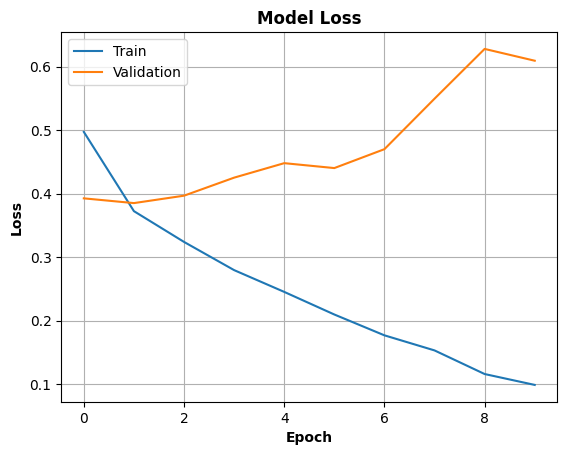

In [19]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch', fontsize=10, fontweight='bold')
plt.ylabel('Loss', fontsize=10, fontweight='bold')
plt.legend(['Train', 'Validation'])
plt.grid(True)  # Add grid
plt.show()

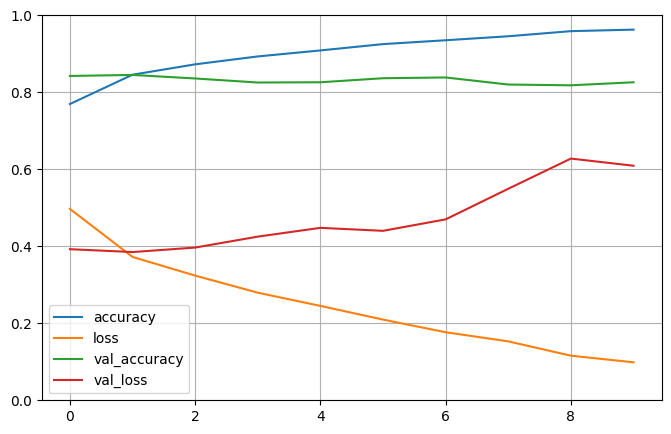

In [20]:
model_loss=pd.DataFrame(history.history)

model_loss.plot (figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [22]:
# Evaluate the model
from keras.models import load_model

Best_model = load_model('Checkpoints/distil_bert_checkpoint.keras')

loss_model, accuracy_model = Best_model.evaluate(X_val, y_val)

print("Proposed Model Validation Loss:", loss_model)
print("Proposed Model Validation Accuracy:", accuracy_model)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 210 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.3903 - sparse_categorical_accuracy: 0.8483
Proposed Model Validation Loss: 0.3849903643131256
Proposed Model Validation Accuracy: 0.8450427055358887


In [23]:
categories = ['Not Disaster', 'Disaster']

48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step
[1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 

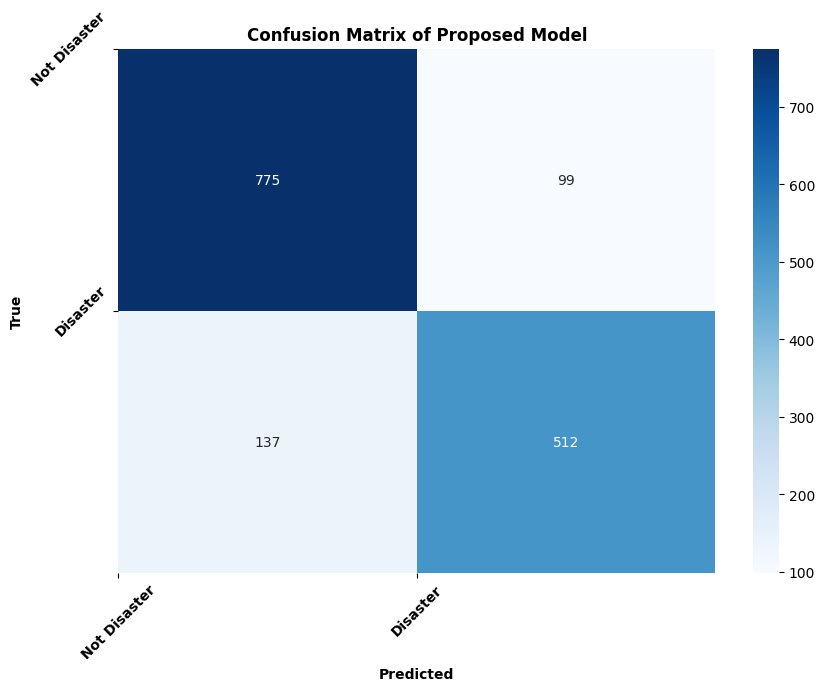

TypeError: only integer scalar arrays can be converted to a scalar index

In [24]:
# Make predictions on the validation dataset
predictions_model = Best_model.predict(X_val)
predicted_categories_model = np.argmax(predictions_model, axis=1)

true_categories_model = y_val
print(true_categories_model)

# Create a confusion matrix
confusion_matrix_model = tf.math.confusion_matrix(true_categories_model, predicted_categories_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Proposed Model", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.xlabel("Predicted", fontsize=10, fontweight='bold')
plt.ylabel("True", fontsize=10, fontweight='bold')
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45, fontsize=10, fontweight='bold')
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45, fontsize=10, fontweight='bold')
plt.show()

# Plot sample images with their predicted and true labels
sample_indices = np.random.choice(range(len(X_val)), size=9, replace=False)
sample_images = X_val[sample_indices]  # Assuming X_val contains images
sample_predictions_model = [categories[predicted_categories_model[i]] for i in sample_indices]
sample_true_labels_model = [categories[true_categories_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = sample_images[i]
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_model[i]}\nTrue: {sample_true_labels_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
# Calculate sensitivity (recall) and specificity for each class
sensitivity = np.zeros(len(categories))
specificity = np.zeros(len(categories))

for i in range(len(categories)):
    tp = confusion_matrix_model[i, i]
    fn = np.sum(confusion_matrix_model[i, :]) - tp
    fp = np.sum(confusion_matrix_model[:, i]) - tp
    tn = np.sum(confusion_matrix_model) - (tp + fn + fp)
    
    sensitivity[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate overall sensitivity and specificity
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)

# Print sensitivity and specificity for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Sensitivity: {sensitivity[i]}")
    print(f"Specificity: {specificity[i]}")
    print()

print(f"Overall Sensitivity: {overall_sensitivity}")
print(f"Overall Specificity: {overall_specificity}")

Class: Not Disaster
Sensitivity: 0.8867276887871853
Specificity: 0.7889060092449923

Class: Disaster
Sensitivity: 0.7889060092449923
Specificity: 0.8867276887871853

Overall Sensitivity: 0.8378168490160889
Overall Specificity: 0.8378168490160889


In [26]:
# DataFrame for true and predicted categories
df = pd.DataFrame({"Y_val": y_val , "Y_predicted": predicted_categories_model})
df.head(8)

,Y_val,Y_predicted
0,1,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,1,0
7,1,0


In [27]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [28]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step


In [29]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.392890
std,3146.427221,0.488468
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [33]:
# Create the directory if it doesn't exist

os.remove('submission/xgb_submission.csv')

if not os.path.exists('submission'):
    os.makedirs('submission')
    
# Now save the submission file
sample_submission.to_csv('submission/submission.csv', index=False)

print("Submission file created: submission.csv")  

Submission file created: submission.csv
